# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from scipy.signal import correlate
import copy
import math


# PRN Generator

In [2]:
SV = {
   1: [2,6],
   2: [3,7],
   3: [4,8],
   4: [5,9],
   5: [1,9],
   6: [2,10],
   7: [1,8],
   8: [2,9],
   9: [3,10],
  10: [2,3],
  11: [3,4],
  12: [5,6],
  13: [6,7],
  14: [7,8],
  15: [8,9],
  16: [9,10],
  17: [1,4],
  18: [2,5],
  19: [3,6],
  20: [4,7],
  21: [5,8],
  22: [6,9],
  23: [1,3],
  24: [4,6],
  25: [5,7],
  26: [6,8],
  27: [7,9],
  28: [8,10],
  29: [1,6],
  30: [2,7],
  31: [3,8],
  32: [4,9],
}

def shift(register, feedback, output):
    """GPS Shift Register

    :param list feedback: which positions to use as feedback (1 indexed)
    :param list output: which positions are output (1 indexed)
    :returns output of shift register:

    """

    out = [register[i-1] for i in output]
    if len(out) > 1:
        out = sum(out) % 2
    else:
        out = out[0]

    fb = sum([register[i-1] for i in feedback]) % 2

    for i in reversed(range(len(register[1:]))):
        register[i+1] = register[i]

    register[0] = fb

    return out

def PRN(sv):

    """Build the CA code (PRN) for a given satellite ID

    :param int sv: satellite code (1-32)
    :returns list: ca code for chosen satellite

    """

    # init registers
    G1 = [1 for i in range(10)]
    G2 = [1 for i in range(10)]

    ca = [] # stuff output in here

    # create sequence
    for i in range(1023):
        g1 = shift(G1, [3,10], [10])
        g2 = shift(G2, [2,3,6,8,9,10], SV[sv]) # <- sat chosen here from table

        # modulo 2 add and append to the code
        ca.append((g1 + g2) % 2)

    # return C/A code!
    return ca

# Fine Doppler Search

In [3]:


def apply_doppler_shift(compdata, fd, fs, doppler_shift, st):
    n = np.arange(len(compdata)) + st
    shift_factor = np.exp(-1j * 2 * np.pi * (fd + doppler_shift) * n / fs)
    return compdata * shift_factor

def correlate(compdata, chunk):
    correlation = fftconvolve(compdata,chunk[::-1], mode='valid')
    # plt.plot(np.imag(correlation))
    # plt.show()
    return correlation

def search_doppler_shift(compdata, st, chunk, fd, fs, search_param = [-10, 1, 10], imag_threshold=300000):
    best_shift = 0
    max_correlation = 0
    prev_min = 1e7
    curr_min = 1e7
    for doppler_shift in [search_param[0]+search_param[1]*i for i in range(int((search_param[2]-search_param[0])/search_param[1]))]:
        shifted_data = apply_doppler_shift(compdata, fd, fs, doppler_shift, st)
        corr = correlate(shifted_data, chunk)
        real_corr = np.real(corr)
        imag_corr = np.imag(corr)
        
        if np.all(np.abs(imag_corr) < imag_threshold):
            # print(imag_corr[:20])
            curr_min = np.max(np.abs(imag_corr)) #Finding max in imag_corr and checking if it is less than prev max
            if (curr_min < prev_min):
                prev_min = curr_min
                best_shift = doppler_shift
                plt.figure(figsize=(10, 6))
                plt.plot(real_corr, label='Real Part', color='blue')
                plt.plot(imag_corr, label='Imaginary Part', color='red')
                plt.title(f'Fine Doppler Correction: {doppler_shift}')
                plt.xlabel('Sample Index')
                plt.ylabel('Correlation Amplitude')
                plt.legend()
                plt.grid(True)
                plt.show()
            # break
    
    return best_shift, max_correlation


In [4]:
def generate_prn_upsample(sv, sample_rate):
    prn = PRN(sv)
    prn = [-1 if x == 0 else x for x in prn]

    prn_upsample = np.zeros(sample_rate//1000)
    n = 0
    for i in range(sample_rate//1000):
        prn_upsample[i] = prn[math.ceil(1000*(i+1)*len(prn)/sample_rate)-1]

    return prn_upsample


# Doppler Shift
doppler = {18 : 0, 12: 2697.905, 13: -2848.802, 10: 2891.328, 5: -2449.682, 15: -1816.517, 23: 2137.817}


In [31]:
def estimate_alpha(filepath, doppler, sampling_rate, sv, preamble_start_ind, fine_doppler):
    print(preamble_start_ind)
    print(fine_doppler)
    data = np.fromfile(filepath, dtype = np.short)
    compdata =  data[0::2] + 1j * data[1::2]
    fs = sampling_rate
    fd = doppler
    prn_upsample = generate_prn_upsample(sv, fs)
    gold_code = []
    # Repeats the PRN code 20 times
    for i in range(20):
        gold_code.append(prn_upsample)
    gold_code = np.array(gold_code).flatten()

    code = [1,0,0,0,1,0,1,1] # Initial 8 bits of the processed I data

    # Generate the input vector from gold code and I values
    v1 = []
    for i in range(len(code)):
        if code[i] == 1:
            v1.append(np.array(gold_code))
        else:
            v1.append(np.multiply(-1,np.array(gold_code)))
    v1 = np.array(v1).flatten()
    est_alpha = []
    for i in range(len(preamble_start_ind)):
        st = preamble_start_ind[i]
        y = copy.deepcopy(compdata[st:st+len(v1)])
        y = apply_doppler_shift(y, fd, fs, fine_doppler[i], st)
        # corr = correlate(, v1)
        alpha_hat = np.dot(v1.T, y)/np.dot(v1.T,v1)
        if np.real(alpha_hat) < 0:
            alpha_hat = -alpha_hat
        print(f"Alpha for SV {sv} at {fine_doppler[i]} Hz and index {st}: {alpha_hat}")
        est_alpha.append(alpha_hat)
        # y1 = y - alpha_hat * v1
    
    return np.mean(est_alpha), np.std(est_alpha)
    


In [32]:
sampling_rate = 4000000
doppler = {18 : 0, 12: 2697.905, 13: -2848.802, 10: 2891.328, 5: -2449.682, 15: -1816.517, 23: 2137.817}
sv = 10

In [33]:
preamble_start_ind = [324143, 24324099, 48324055, 72324011, 96323967]
fine_doppler = [-2.31, -2.07, -1.58, -1.12, -0.5]
filepath = '/home/joel/gps-sdr-sim-master/prn_gain1/split_data/mydataa'
alp1, std1 = estimate_alpha(filepath, doppler[sv], sampling_rate, sv, preamble_start_ind, fine_doppler)

print(f"Mean Alpha: {alp1}, Std: {std1}")


[324143, 24324099, 48324055, 72324011, 96323967]
[-2.31, -2.07, -1.58, -1.12, -0.5]
Alpha for SV 10 at -2.31 Hz and index 324143: (94.03503186484114+2.0430024066819j)
Alpha for SV 10 at -2.07 Hz and index 24324099: (93.78289707037548+1.40213777516384j)
Alpha for SV 10 at -1.58 Hz and index 48324055: (93.61493364474006-1.4600490025475592j)
Alpha for SV 10 at -1.12 Hz and index 72324011: (94.88692890194748+9.458225121194333j)
Alpha for SV 10 at -0.5 Hz and index 96323967: (93.98431039540822+1.5391908796292892j)
Mean Alpha: (94.06082037546248+2.596501436024361j), Std: 3.6702766979299057


In [34]:
preamble_start_ind = [324143, 24324099, 48324055, 72324011, 96323967]
fine_doppler = [-2.31, -2.07, -1.58, -1.12, -0.5]
filepath = '/home/joel/gps-sdr-sim-master/prn_gain0.9/split_data/mydataa'
alp2, std2 = estimate_alpha(filepath, doppler[sv], sampling_rate, sv, preamble_start_ind, fine_doppler)

print(f"Mean Alpha: {alp2}, Std: {std2}")

[324143, 24324099, 48324055, 72324011, 96323967]
[-2.31, -2.07, -1.58, -1.12, -0.5]
Alpha for SV 10 at -2.31 Hz and index 324143: (83.18753590865649+1.810651343648943j)
Alpha for SV 10 at -2.07 Hz and index 24324099: (82.96531516867287+1.2336090431495708j)
Alpha for SV 10 at -1.58 Hz and index 48324055: (82.81229316012815-1.2807507706590624j)
Alpha for SV 10 at -1.12 Hz and index 72324011: (83.95769505053278+8.379688133034337j)
Alpha for SV 10 at -0.5 Hz and index 96323967: (83.15029909883373+1.3605580119119536j)
Mean Alpha: (83.21462767736482+2.3007511522171487j), Std: 3.250373367059796


In [ ]:
preamble_start_ind = [324143, 24324099, 48324055, 72324011, 96323967]
fine_doppler = [-2.31, -2.07, -1.58, -1.12, -0.5]
filepath = '/home/joel/gps-sdr-sim-master/prn_gain0.9/split_data/mydataa'
alp2, std2 = estimate_alpha(filepath, doppler[sv], sampling_rate, sv, preamble_start_ind, fine_doppler)

print(f"Mean Alpha: {alp2}, Std: {std2}")

In [35]:
preamble_start_ind = [324143, 24324099, 48324055, 72324011, 96323967]
fine_doppler = [-2.31, -2.07, -1.58, -1.12, -0.5]
filepath = '/home/joel/gps-sdr-sim-master/prn_gain0.75/split_data/mydataa'
alp3, std3 = estimate_alpha(filepath, doppler[sv], sampling_rate, sv, preamble_start_ind, fine_doppler)

print(f"Mean Alpha: {alp3}, Std: {std3}")

[324143, 24324099, 48324055, 72324011, 96323967]
[-2.31, -2.07, -1.58, -1.12, -0.5]
Alpha for SV 10 at -2.31 Hz and index 324143: (70.52539096571222+1.5309196873677118j)
Alpha for SV 10 at -2.07 Hz and index 24324099: (70.33665743211043+1.05454599509438j)
Alpha for SV 10 at -1.58 Hz and index 48324055: (70.21111661347898-1.100061916993516j)
Alpha for SV 10 at -1.12 Hz and index 72324011: (71.15298703043086+7.08671602877979j)
Alpha for SV 10 at -0.5 Hz and index 96323967: (70.4842597904843+1.1534339973649368j)
Mean Alpha: (70.54208236644337+1.9451107583226606j), Std: 2.750605664547339


In [36]:
preamble_start_ind = [324143, 24324099, 48324055, 72324011, 96323967]
fine_doppler = [-2.31, -2.07, -1.58, -1.12, -0.5]
filepath = '/home/joel/gps-sdr-sim-master/prn_gain0.5/split_data/mydataa'
alp4, std4 = estimate_alpha(filepath, doppler[sv], sampling_rate, sv, preamble_start_ind, fine_doppler)

print(f"Mean Alpha: {alp4}, Std: {std4}")

[324143, 24324099, 48324055, 72324011, 96323967]
[-2.31, -2.07, -1.58, -1.12, -0.5]
Alpha for SV 10 at -2.31 Hz and index 324143: (47.01480854410043+1.0183163825149681j)
Alpha for SV 10 at -2.07 Hz and index 24324099: (46.89141400964416+0.70508953269886j)
Alpha for SV 10 at -1.58 Hz and index 48324055: (46.80926657694561-0.7414777188787571j)
Alpha for SV 10 at -1.12 Hz and index 72324011: (47.42547299985163+4.715282612902705j)
Alpha for SV 10 at -0.5 Hz and index 96323967: (46.98485235092424+0.7700693777543366j)
Mean Alpha: (47.02516289629322+1.2934560373984225j), Std: 1.8315099449020094


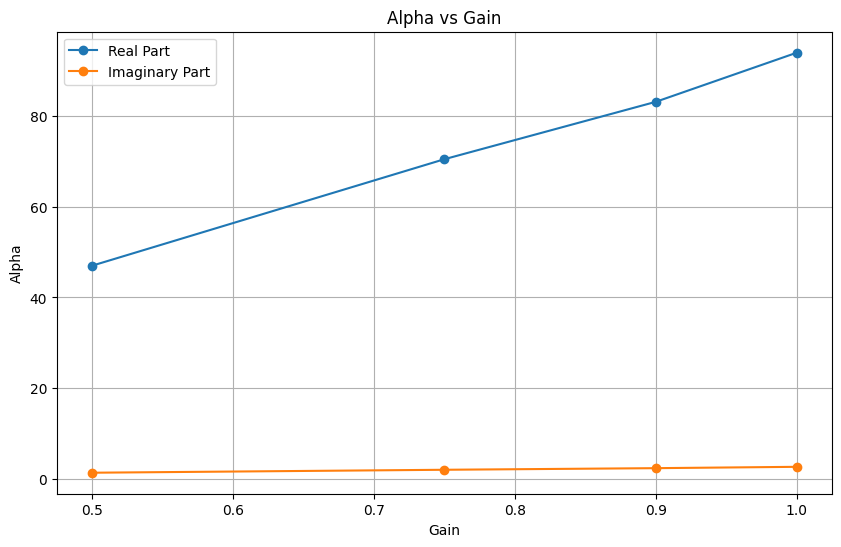

In [37]:
gains = [0.5, 0.75, 0.9, 1]
alphas = [alp4, alp3, alp2, alp1]

plt.figure(figsize=(10, 6))
plt.plot(gains, [np.real(alpha) for alpha in alphas], marker='o', label='Real Part')
plt.plot(gains, [np.imag(alpha) for alpha in alphas], marker='o', label='Imaginary Part')
plt.title('Alpha vs Gain')
plt.xlabel('Gain')
plt.ylabel('Alpha')
plt.legend()
plt.grid(True)
plt.show()